In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import sklearn.linear_model as lm

# to remove spines at the top and right
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
data = pd.read_csv('../data/concat_data.csv', index_col=0)
data

,mortality_decrease,movement_energy,corridor_netws,corridor_year,buffer_netws,buffer_year
0,0.01,200.000000,29.0,4.0,0.0,-999.0
1,0.01,288.888889,56.0,2.0,38.0,5.0
2,0.01,377.777778,39.0,2.0,28.0,3.0
3,0.01,466.666667,50.0,2.0,7.0,95.0
4,0.01,555.555556,40.0,3.0,43.0,4.0
...,...,...,...,...,...,...
245,0.15,644.444444,58.0,2.0,67.0,13.0
246,0.15,733.333333,64.0,2.0,62.0,80.0
247,0.15,822.222222,55.0,4.0,62.0,3.0
248,0.15,911.111111,60.0,2.0,62.0,42.0


In [3]:
data['buff_occ'] = data.buffer_year != -999
data['corr_occ'] = data.corridor_year != -999

In [4]:
std_data = data.groupby(['mortality_decrease', 'movement_energy']).std()
mean_data = data.groupby(['mortality_decrease', 'movement_energy']).mean()

buffer_occupied = mean_data.buff_occ.values
corridor_occupied = mean_data.corr_occ.values

heat_data_buffers = pd.DataFrame(np.reshape(buffer_occupied, (10, 10)), 
                         index = np.round(np.unique(data['mortality_decrease']), 3), 
                         columns = np.round(np.unique(data['movement_energy'])) )


heat_data_corridors = pd.DataFrame(np.reshape(corridor_occupied, (10, 10)), 
                         index = np.round(np.unique(data['mortality_decrease']), 3), 
                         columns = np.round(np.unique(data['movement_energy'])) )

In [5]:
np.round(np.unique(data['mortality_decrease']), 3)

array([0.01 , 0.026, 0.041, 0.057, 0.072, 0.088, 0.103, 0.119, 0.134,
       0.15 ])

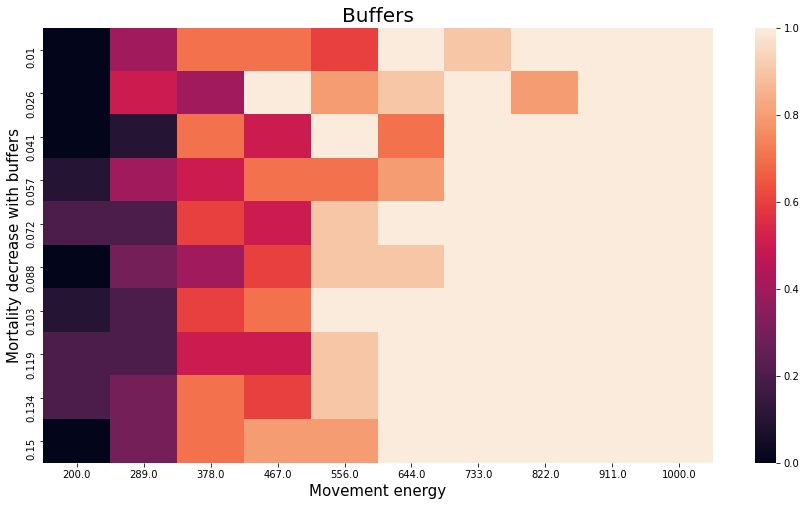

In [6]:
plt.figure(figsize= (15,8))
sns.heatmap(heat_data_buffers, annot=False, square = False)
plt.ylabel('Mortality decrease with buffers', size=15)
plt.xlabel('Movement energy', size=15)
plt.title('Buffers', size=20)
plt.show();

In [7]:
X, Y = data.movement_energy.values.reshape(-1, 1), data.buff_occ.values
log_reg_buffer = lm.LogisticRegression().fit(X,Y)

X, Y = data.movement_energy.values.reshape(-1, 1), data.corr_occ.values
log_reg_corridor = lm.LogisticRegression().fit(X,Y)

x_pred = np.linspace(200, 1000, 1000).reshape(-1,1)
y_pred_buffer =log_reg_buffer.predict_proba(x_pred)[:, 1]
y_pred_corridor =log_reg_corridor.predict_proba(x_pred)[:, 1]

In [8]:
swarm_x = np.tile(np.round(data.movement_energy), 2)
swarm_y = np.concatenate([data.buff_occ.values, data.corr_occ.values])
swarm_hue = np.concatenate([np.repeat('Buffer', 1000), np.repeat('Corridor', 1000)])

df_prep = {'x': swarm_x,
     'y': swarm_y,
     'Scenario': swarm_hue}

df = pd.DataFrame(df_prep)
#df.y = df.y.astype("category")



upper,lower =50, -50
mu,sigma = 0, 15
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
df['x_jit'] = df.x + X.rvs(2000)


upper,lower =0.4, -0.4
mu,sigma = 0, 0.1
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

df['y_jit'] = df.y + X.rvs(2000)

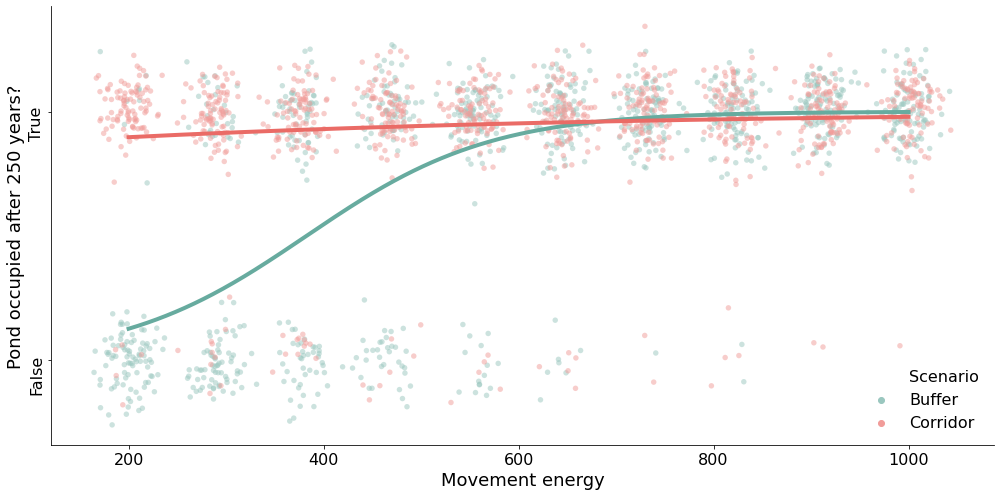

In [10]:
plt.figure(figsize=(14,7))

sns.scatterplot(data=df, x="x_jit", y="y_jit", hue="Scenario", alpha=0.5, s=30,
               palette=['#9AC7BF', '#F19C99'], edgecolor = None, linewidth = 0)

plt.plot(x_pred, y_pred_buffer, lw=4, color='#67AB9F')
plt.plot(x_pred, y_pred_corridor, lw=4, color='#EA6B66')

plt.ylabel('Pond occupied after 250 years?', size=18)
plt.xlabel('Movement energy', size=18)
plt.yticks([0,1], ['False','True'], rotation=90, size=16)
plt.xticks(size=16)
plt.legend(frameon=False, prop={'size': 16})
plt.tight_layout()
plt.savefig('../results/occ_ponds.svg');